# Questions to answer

- Given 3-D coordinates and clustering labels, is the task easy enough to train it with 5 samples.
- If not, does using similarity instead of labels help? Compare similarities between samples(or between sample with prototype) instead of direclty classifying.
- If not, does high-dimensional encoding(ssp) help?



In [1]:
%matplotlib notebook

import pickle
import pprint as pp
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.cluster import AgglomerativeClustering
from sklearn.covariance import MinCovDet #TODO: reconsider this in case we have multimodal distributions
from scipy.stats import trim_mean


seqs = []  

logfile_path = 'data/1599166289/data.pickle'
with open(logfile_path, "rb") as logfile:
    while True:
        try:
            seqs.append(pickle.load(logfile))
        except EOFError:
            break  
            
minimum_demonstration_path = 'data/1599153598/data.pickle' # Data with only one bolt and one nut

with open(minimum_demonstration_path, "rb") as logfile:
    while True:
        try:
            seqs.append(pickle.load(logfile))
        except EOFError:
            break   
            
seqs_success = []
for seq in seqs:
    if len(seq) == 4:
        seqs_success.append(seq)


In [2]:
def fetch_data(x, force_success = True):
    '''
    x is a list of file_path
    '''
    seqs = []  
    for file_path in x:
        with open(file_path, "rb") as logfile:
            while True:
                try:
                    seqs.append(pickle.load(logfile))
                except EOFError:
                    break  
    seqs_success = []
    if force_success:
        for seq in seqs:
            if len(seq) == 4:
                seqs_success.append(seq)
        seqs = seqs_success
    data_nut = []
    data_bolt = []
    for seq in seqs:
        for step in seq:
            temp_nut = [list(obj['pos']) + list(obj['orn']) for obj in step['objs'] if obj['class'] == 'nut']
            temp_bolt = [list(obj['pos']) + list(obj['orn']) for obj in step['objs'] if obj['class'] == 'bolt']
            data_nut += temp_nut
            data_bolt += temp_bolt

    data_nut = np.asarray(data_nut).T
    data_bolt = np.asarray(data_bolt).T

    coord_nut = data_nut[:3,:]
    coord_bolt = data_bolt[:3,:]
    delta = 0.01
    for i, val in enumerate(coord_bolt[1]):
        if val > 0.064:
            coord_bolt[1][i] += delta
    
    return coord_nut, coord_bolt

In [3]:
a, b = fetch_data(['data/1599166289/data.pickle', 'data/1599153598/data.pickle'])

# Clustering using Agglomerative

In [10]:
# Clustering

def p_norm_distance(data, p):
    
    n = data.shape[1]
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            difference = np.abs(data[:, i] - data[:, j])
            distances[i,j] = np.sum(difference ** p) ** (1 / p)
    distances = distances + distances.T
    return distances

def clustering(distances, thres):
    # compute distances using p-norm with -ve exponent
    # note exponent can't be too large; we want closeness in multiple dimensions to be somewhat better than closeness in only one
    # cluster using these distances
    ac = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='average', distance_threshold= thres)
    estimated_labels = ac.fit_predict(distances)
    return estimated_labels

def add_noise(data):
    shape = data.shape
    noise = np.random.normal(0, 0.00052, shape)
    return data + noise

p = -3
thres = 0.0015
data_nut = []
data_bolt = []
for seq in seqs_success:
    for step in seq:
        temp_nut = [list(obj['pos']) + list(obj['orn']) for obj in step['objs'] if obj['class'] == 'nut']
        temp_bolt = [list(obj['pos']) + list(obj['orn']) for obj in step['objs'] if obj['class'] == 'bolt']
        data_nut += temp_nut
        data_bolt += temp_bolt
        
data_nut = np.asarray(data_nut).T
data_bolt = np.asarray(data_bolt).T

coord_nut = data_nut[:3,:]
coord_bolt = data_bolt[:3,:]

delta = 0.01
for i, val in enumerate(coord_bolt[1]):
    if val > 0.064:
        coord_bolt[1][i] += delta

# coord_nut = add_noise(data_nut[:3,:])
# coord_bolt = add_noise(data_bolt[:3,:])
p_distances_nut = p_norm_distance(coord_nut, p)
p_distances_bolt = p_norm_distance(coord_bolt, p)

estimated_labels_nut = clustering(p_distances_nut, thres)
estimated_labels_bolt = clustering(p_distances_bolt, thres)

C:\Users\xyao0\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.


In [12]:
print(np.max(estimated_labels_nut))
print(np.max(estimated_labels_bolt))

1
2


<IPython.core.display.Javascript object>


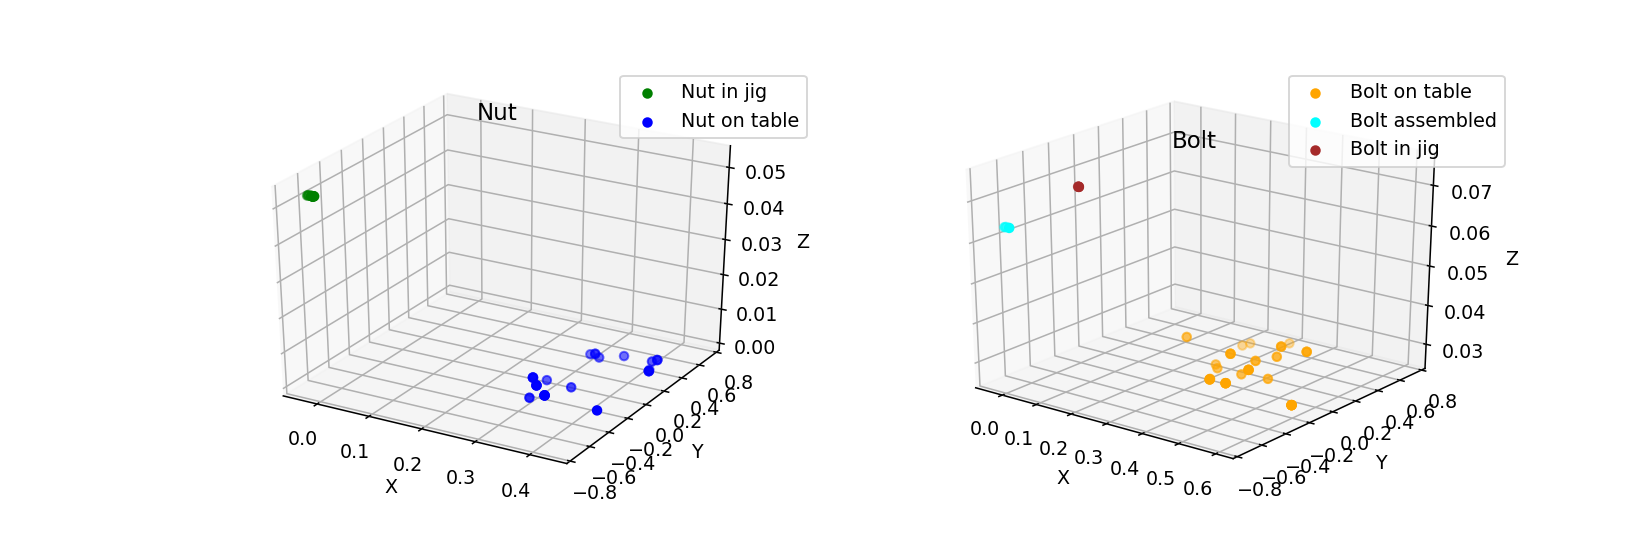

In [13]:
label_nut = ['Nut in jig', 'Nut on table']
label_bolt = ['Bolt on table', 'Bolt assembled', 'Bolt in jig']
colors = ['green','blue','orange','cyan','brown' ]

fig = plt.figure(1, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
for label in np.unique(estimated_labels_nut):
    indices = np.nonzero(estimated_labels_nut==label)
    samples = data_nut[:,indices].squeeze()
    if samples.ndim ==1:
        x_points = samples[0]
        y_points = samples[1]
        z_points = samples[2]
    else:
        x_points = samples[0,:]
        y_points = samples[1,:]
        z_points = samples[2,:]
    ax.scatter3D(x_points,z_points, y_points, c = colors[label], label='{}'.format(label_nut[label]))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([-0.8,0.8])
    ax.set_zlabel('Z')
    plt.title('Nut')
    plt.legend(loc = 'best',bbox_to_anchor=(1.05, 1))
ax = fig.add_subplot(1, 2, 2, projection='3d')
for label in np.unique(estimated_labels_bolt):
    '''
    0: bolt on table
    1: bolt assembled
    2: bolt in jig'''
    indices = np.nonzero(estimated_labels_bolt==label)
    samples = data_bolt[:,indices].squeeze()
    if samples.ndim ==1:
        x_points = samples[0]
        y_points = samples[1]
        z_points = samples[2]
    else:
        x_points = samples[0,:]
        y_points = samples[1,:]
        z_points = samples[2,:]
    ax.scatter3D(x_points,z_points, y_points, c = colors[label + 2], label='{}'.format(label_bolt[label]))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([-0.8,0.8])
    ax.set_zlabel('Z')
    plt.title('Bolt')
    plt.legend(loc = 'best',bbox_to_anchor=(1.05, 1))
# plt.savefig('Data_clustered.eps', format='eps')

In [8]:
data_nut, data_bolt = fetch_data(['data/test/data.pickle'])
p_distances_nut = p_norm_distance(data_nut, p)
p_distances_bolt = p_norm_distance(data_bolt, p)

estimated_labels_nut = clustering(p_distances_nut, thres)
estimated_labels_bolt = clustering(p_distances_bolt, thres)

C:\Users\xyao0\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.


In [9]:
print(max(estimated_labels_nut))
print(max(estimated_labels_bolt))

2
3


<IPython.core.display.Javascript object>


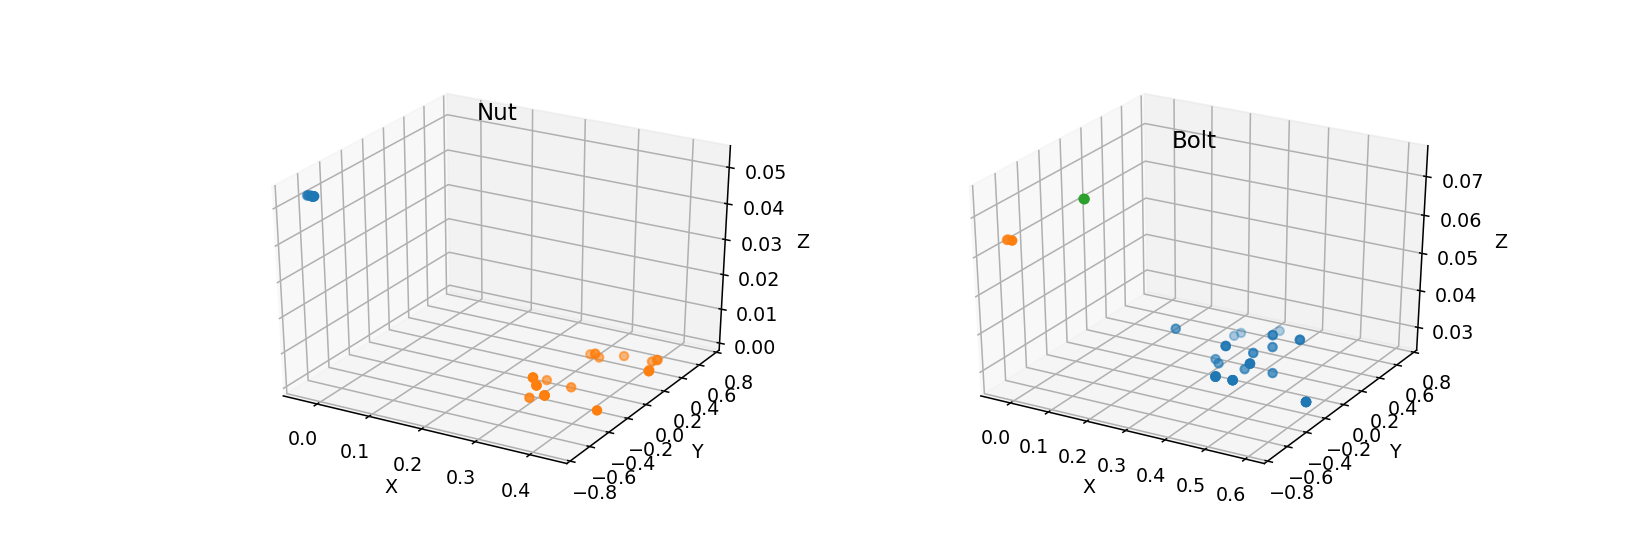

In [14]:
labels_nut = estimated_labels_nut
labels_bolt = estimated_labels_bolt
fig = plt.figure(2, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
for label in np.unique(labels_nut):
    indices = np.nonzero(labels_nut==label)
    samples = data_nut[:,indices].squeeze()
    if samples.ndim ==1:
        x_points = samples[0]
        y_points = samples[1]
        z_points = samples[2]
    else:
        x_points = samples[0,:]
        y_points = samples[1,:]
        z_points = samples[2,:]
    ax.scatter3D(x_points,z_points, y_points )
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([-0.8,0.8])
    ax.set_zlabel('Z')
    plt.title('Nut')
    
ax = fig.add_subplot(1, 2, 2, projection='3d')
for label in np.unique(labels_bolt):
    indices = np.nonzero(labels_bolt==label)
    samples = data_bolt[:,indices].squeeze()
    if samples.ndim ==1:
        x_points = samples[0]
        y_points = samples[1]
        z_points = samples[2]
    else:
        x_points = samples[0,:]
        y_points = samples[1,:]
        z_points = samples[2,:]
    ax.scatter3D(x_points,z_points, y_points)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([-0.8,0.8])
    ax.set_zlabel('Z')
    plt.title('Bolt')
# plt.savefig('Data_clustered.eps', format='eps')

In [17]:
n_train = 5
x_train = []
y_train = []
for i in range(3):
    ind = list(np.where(estimated_labels_bolt == i)[0][:n_train])
    print(ind)
    for j in ind:
        x_train.append(coord_bolt[:,j])
        y_train.append(i)


[0, 1, 2, 3, 4]
[9, 21, 33, 45, 51]
[6, 18, 30, 42, 50]


In [82]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.concatenate((samples_bolt[0], samples_bolt[1], samples_bolt[2]), axis = 0) # n by d
y_test = np.zeros(x_test.shape[0])
y_test[100:200], y_test[200:] = 1, 2
d = x_train.shape[1]

In [93]:
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

In [88]:
x_train.shape

(15, 3)

In [44]:
samples_bolt[0].shape

(100, 3)

In [8]:
print(np.max(estimated_labels_nut))
print(np.max(estimated_labels_bolt))

1
2


In [9]:
estimated_labels_nut

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1])

In [10]:
estimated_labels_bolt

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 2, 0, 0, 0, 0, 1, 2])

## Clustering plot

In [2]:
from .. import hrr
def ssp_encode(data, C, coord_only = True):
    # C is the cleanup memory that contains some concepts needed 
    n = data.shape[1] # number of datapoints
    m = np.zeros((dim, n))
    for i in range(n):
        x = data[0, i]
        y = data[1, i]
        z = data[2, i]
        X = C.get('X')
        Y = C.get('Y')
        Z = C.get('Z')

        x_ssp = np.fft.ifft(np.fft.fft(X)**x).real
        y_ssp = np.fft.ifft(np.fft.fft(Y)**y).real
        z_ssp = np.fft.ifft(np.fft.fft(Z)**z).real

        if coord_only == True:
            m[:, i] = bind(bind(x_ssp, y_ssp), z_ssp)
        else:
            pass
    return m

ValueError: attempted relative import beyond top-level package

In [ ]:
import

In [33]:
dim = 128
concepts = ['bolt', 'nut', 'X', 'Y', 'Z']
noise = 0
C = CleanupMemory(concepts, dim, noise)

In [175]:
p = -2
ssp_nut = ssp_encode(data_nut, C)
ssp_bolt = ssp_encode(data_bolt, C)
p_distance_nut_ssp = (p_norm_distance(ssp_nut, p ))
p_distance_bolt_ssp = (p_norm_distance(ssp_bolt, p ))

thres = 0.0004
# thres = 0.9
estimated_labels_nut_ssp = clustering(p_distance_nut_ssp, thres)
estimated_labels_bolt_ssp = clustering(p_distance_bolt_ssp, thres)

print(np.max(estimated_labels_nut_ssp))
print(np.max(estimated_labels_bolt_ssp))

2
1


/home/Xueyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.


In [150]:
estimated_labels_nut

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0])

In [151]:
estimated_labels_nut_ssp

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 2, 1, 0, 2, 1, 0, 2, 1,
       0, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 2, 1, 1, 1])

In [152]:
estimated_labels_bolt

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 1, 0, 0, 0, 0, 2, 1])

In [153]:
estimated_labels_bolt_ssp

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1])

In [154]:
def cos_distance(data):
    n = data.shape[1]
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            distance = 1 - np.dot(data[:, i],data[:, j])
            if distance < 0:
                distances[i,j] = 0
            else:
                distances[i,j] = 1 - np.dot(data[:, i],data[:, j])
    distances = distances + distances.T
    return distances
    

In [162]:
cos_distance_nut_ssp = cos_distance(ssp_nut)
cos_distance_bolt_ssp = cos_distance(ssp_bolt)

thres = 0.4
estimated_labels_nut_ssp = clustering(cos_distance_nut_ssp, thres)
estimated_labels_bolt_ssp = clustering(cos_distance_bolt_ssp, thres)

In [163]:
print(np.max(estimated_labels_nut_ssp))
print(np.max(estimated_labels_bolt_ssp))

2
1


In [168]:
estimated_labels_nut


array([2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 1,
       2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 2, 1, 2, 2, 1, 2,
       2, 1, 2, 2, 0, 1, 1, 1])

In [169]:
estimated_labels_nut_ssp

array([2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 1,
       2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 2, 1, 2, 2, 1, 2,
       2, 1, 2, 2, 0, 1, 1, 1])

In [170]:
estimated_labels_bolt

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 1, 0, 0, 0, 0, 2, 1])

In [171]:
estimated_labels_bolt_ssp

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1])

<IPython.core.display.Javascript object>


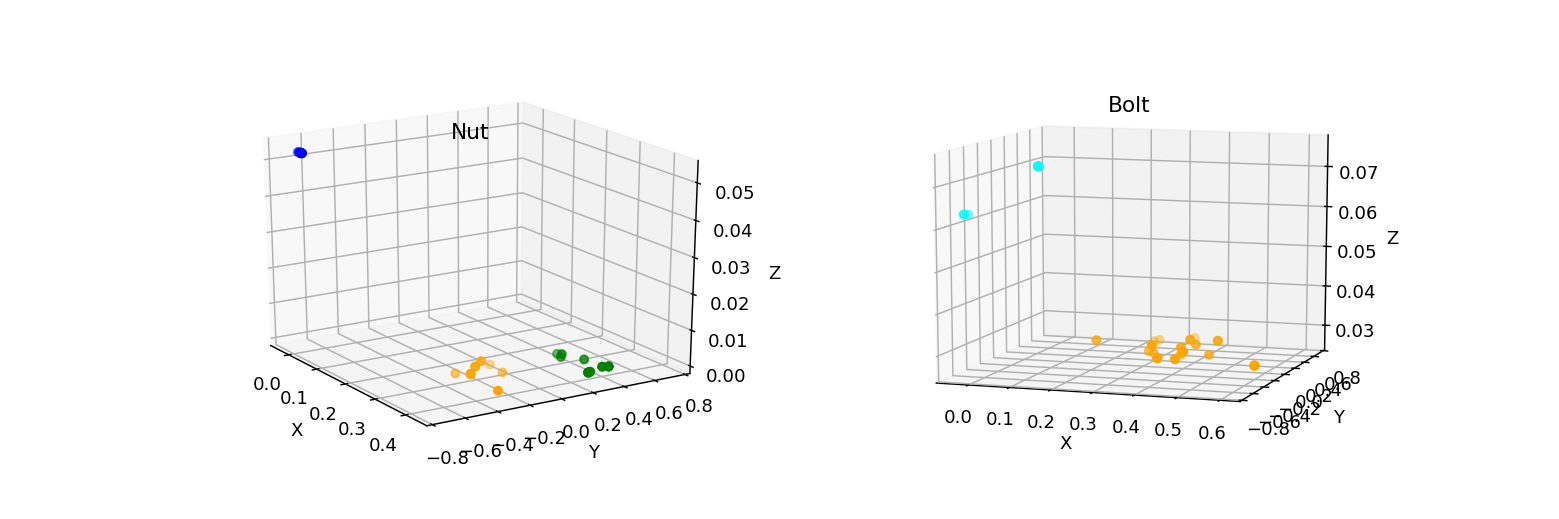

In [176]:
labels_nut = estimated_labels_nut_ssp
labels_bolt = estimated_labels_bolt_ssp
fig = plt.figure(2, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
for label in np.unique(labels_nut):
    indices = np.nonzero(labels_nut==label)
    samples = data_nut[:,indices].squeeze()
    if samples.ndim ==1:
        x_points = samples[0]
        y_points = samples[1]
        z_points = samples[2]
    else:
        x_points = samples[0,:]
        y_points = samples[1,:]
        z_points = samples[2,:]
    ax.scatter3D(x_points,z_points, y_points, c = colors[label], )
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([-0.8,0.8])
    ax.set_zlabel('Z')
    plt.title('Nut')
    
ax = fig.add_subplot(1, 2, 2, projection='3d')
for label in np.unique(labels_bolt):
    indices = np.nonzero(labels_bolt==label)
    samples = data_bolt[:,indices].squeeze()
    if samples.ndim ==1:
        x_points = samples[0]
        y_points = samples[1]
        z_points = samples[2]
    else:
        x_points = samples[0,:]
        y_points = samples[1,:]
        z_points = samples[2,:]
    ax.scatter3D(x_points,z_points, y_points, c = colors[label + 2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([-0.8,0.8])
    ax.set_zlabel('Z')
    plt.title('Bolt')
# plt.savefig('Data_clustered.eps', format='eps')

# Clustering using DBSCAN

In [7]:
# Clustering
from sklearn.cluster import DBSCAN

def p_norm_distance(data, p):
    
    n = data.shape[1]
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            difference = np.abs(data[:, i] - data[:, j])
            distances[i,j] = np.sum(difference ** p) ** (1 / p)
    distances = distances + distances.T
    return distances

def clustering(distances, thres):
    # compute distances using p-norm with -ve exponent
    # note exponent can't be too large; we want closeness in multiple dimensions to be somewhat better than closeness in only one
    # cluster using these distances
    ac =DBSCAN(eps= thres, min_samples= 5, metric='precomputed')
    estimated_labels = ac.fit_predict(distances)
    return estimated_labels


def add_noise(data):
    shape = data.shape
    noise = np.random.normal(0, 0.00012, shape)
    return data + noise
    
p = -3
thres = 0.0005
data_nut = []
data_bolt = []
for seq in seqs_success:
    for step in seq:
        temp_nut = [list(obj['pos']) + list(obj['orn']) for obj in step['objs'] if obj['class'] == 'nut']
        temp_bolt = [list(obj['pos']) + list(obj['orn']) for obj in step['objs'] if obj['class'] == 'bolt']
        data_nut += temp_nut
        data_bolt += temp_bolt
data_nut = np.asarray(data_nut).T
data_bolt = np.asarray(data_bolt).T

coord_nut = data_nut[:3,:]
coord_bolt = data_bolt[:3,:]

coord_nut = add_noise(data_nut[:3,:])
coord_bolt = add_noise(data_bolt[:3,:])
p_distances_nut = p_norm_distance(coord_nut, p)
p_distances_bolt = p_norm_distance(coord_bolt, p)


estimated_labels_nut = clustering(p_distances_nut, thres)
estimated_labels_bolt = clustering(p_distances_bolt, thres)

## Build models

In [144]:
def build_model(estimated_labels, data_concat):
    models = []
    # model the distribution of each cluster robustly in case there are misclassifications
    for label in np.unique(estimated_labels):
        indices = np.nonzero(estimated_labels == label)
        samples = data_concat[:, indices].squeeze()

    #     print('Group {} means and standard deviations'.format(label))
        
        if samples.ndim == 1:
            means = samples
            covariance = np.zeros((3,3))
        else:
            means = trim_mean(samples, 0, axis=1)
            mcd = MinCovDet(support_fraction=1).fit(samples.T)
            covariance = mcd.covariance_
#         standard_deviations = np.diag(mcd.covariance_)**.5
        models.append([means, covariance, label - min(estimated_labels)])
    return models

models_nut = build_model(estimated_labels_nut, data_nut)
n_models_nut = len(models_nut)
models_bolt = build_model(estimated_labels_bolt + n_models_nut, data_bolt)
# models = models_nut + models_bolt

C:\Users\xyao0\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
C:\Users\xyao0\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
C:\Users\xyao0\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
C:\Users\xyao0\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


## Generated priors

In [145]:
with open('states_model/models_nut.pkl', 'wb') as f:
    pickle.dump(models_nut, f)
    
with open('states_model/models_bolt.pkl', 'wb') as f:
    pickle.dump(models_bolt, f)

<IPython.core.display.Javascript object>


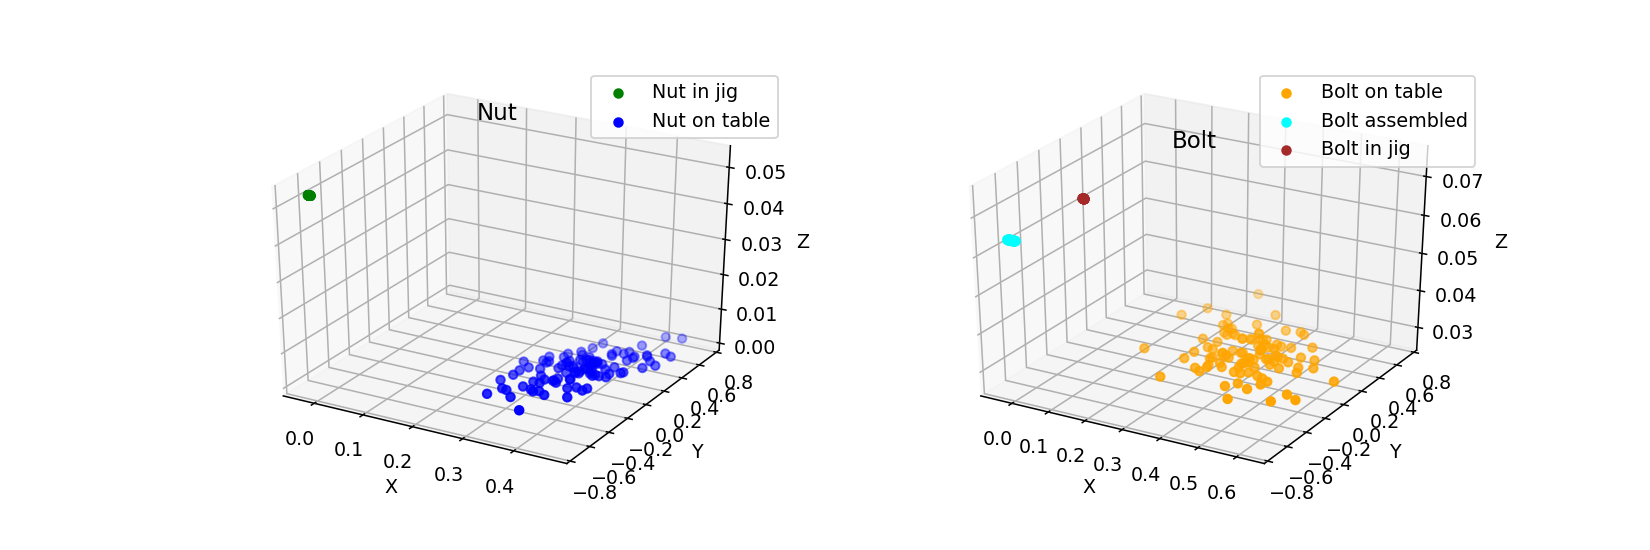

In [143]:
label_nut = ['Nut in jig', 'Nut on table']
label_bolt = ['Bolt on table', 'Bolt assembled', 'Bolt in jig']
colors = ['green','blue','orange','cyan','brown' ]
n_samples = 100
samples_nut = []
samples_bolt = []
for model in models_nut:
    samples_nut.append(np.random.multivariate_normal(model[0][:3] , model[1][:3,:3], n_samples))
for model in models_bolt:
    samples_bolt.append(np.random.multivariate_normal(model[0][:3] , model[1][:3,:3], n_samples))

fig = plt.figure(3, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')

for i in range(len(models_nut)):

    samples = samples_nut[i].T
    x_points = samples[0,:]
    y_points = samples[1,:]
    z_points = samples[2,:]
    ax.scatter3D(x_points,z_points, y_points, c = colors[i], label='{}'.format(label_nut[i]))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([-0.8,0.8])
    ax.set_zlabel('Z')
    plt.title('Nut')
    plt.legend(loc = 'best')
ax = fig.add_subplot(1, 2, 2, projection='3d')
for i in range(len(models_bolt)):
    '''
    0: bolt on table
    1: bolt assembled
    2: bolt in jig
    '''
    samples = samples_bolt[i].T
    x_points = samples[0,:]
    y_points = samples[1,:]
    z_points = samples[2,:]
    ax.scatter3D(x_points,z_points, y_points, c = colors[i + 2], label='{}'.format(label_bolt[i]))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([-0.8,0.8])
    ax.set_zlabel('Z')
    plt.title('Bolt')
    plt.legend(loc = 'best')
# plt.savefig('Genearted_priors.eps', format='eps')

In [7]:
def pred_label(pos, models):
    dists = []
    for model in models:
        pos_means = model[0][:3]
        covirance = model[1]
        distance = p_norm_distance(pos, pos_means, p = -3)
        dists.append(distance)
    model_ind = np.argmin(dists)
    return model_ind


def get_global_state_vecs(seq, models_nut, models_bolt):
    '''
    Return a n by m array. n is number of action +1. m is the number of local states
    '''
    num_global_states = len(seq) # number of action + 1
    num_local_states = len(models_nut + models_bolt)
    state_arr = np.zeros((num_global_states, num_local_states))
    for i,step in enumerate(seq):
        arr = np.zeros(num_local_states)
        for obj in step['objs']:
            pos = obj['pos']      
            if obj['class'] == 'nut':
                ind = pred_label(pos, models_nut)
                arr[ind] = 1
            elif obj['class'] == 'bolt':
                ind = pred_label(pos, models_bolt)
                arr[ind + len(models_nut)] = 1
        state_arr[i] = state_arr[i] + arr
 
    return state_arr

# Get preconditions

In [8]:
import pickle

num_global_states = len(seqs[0]) # number of action + 1
num_local_states = len(models_nut + models_bolt)
sum_global_state_vecs = np.zeros((num_global_states, num_local_states))
actions = ['PUT_NUT_IN_JIG', 'PUT_BOLT_IN_JIG', 'ASSEMBLE']
preconditions = {}
for seq in seqs:
    if len(seq) == 4: # No failure actions
        global_state_vecs = get_global_state_vecs(seq, models_nut, models_bolt)
        sum_global_state_vecs += global_state_vecs
sum_global_state_vecs = (sum_global_state_vecs == np.max(sum_global_state_vecs)).astype(int) # The entry with max value is 1, other entries are zero
for i, action in enumerate(actions):
    preconditions[action] = np.where(sum_global_state_vecs[i])[0]
#     print(f'The index of preconditions of action {action} is {np.where(sum_global_state_vecs[i])[0]}')
print(preconditions)

with open('preconditions.pkl', 'wb') as f:
    pickle.dump(preconditions, f)

{'PUT_NUT_IN_JIG': array([1, 2]), 'PUT_BOLT_IN_JIG': array([0, 2]), 'ASSEMBLE': array([0, 4])}


# Get effects

In [9]:
actions = ['PUT_NUT_IN_JIG', 'PUT_BOLT_IN_JIG', 'ASSEMBLE']
num_actions = len(actions)
num_local_states = len(models_nut + models_bolt)
sum_of_diff = np.zeros((num_actions, num_local_states))
effects = {}
for seq in seqs:
    diff_between_states = np.zeros((num_actions, num_local_states))
    if len(seq) == 4: # No failure actions
        global_state_vecs = get_global_state_vecs(seq, models_nut, models_bolt)
        for i in range(len(actions)):
            diff_between_states[i,:] = global_state_vecs[i + 1] - global_state_vecs[i]
    sum_of_diff += diff_between_states
sum_of_diff = (sum_of_diff == np.max(sum_of_diff)).astype(int) # The entry with max value is 1, other entries are zero
for i, action in enumerate(actions):
    effects[action] = np.where(sum_of_diff[i])[0]
#     print(f'The index of effct of action {action} is {np.where(sum_of_diff[i])[0]}')
print(effects)
with open('effects.pkl', 'wb') as f:
    pickle.dump(effects, f)

{'PUT_NUT_IN_JIG': array([0]), 'PUT_BOLT_IN_JIG': array([4]), 'ASSEMBLE': array([3])}


## Test set

In [103]:
# logfile_path = '../sim_data/1600388944/data.pickle' is what in testing folder

seqs_test = []

logfile_path = 'data/test/data.pickle' 
with open(logfile_path, "rb") as logfile:
    while True:
        try:
            seqs_test.append(pickle.load(logfile))
        except EOFError:
            break        
z = 0
test_nut = []
test_bolt = []
for seq in seqs_test:
    for step in seq:
        if step['action'] == 'PUT_NUT_IN_JIG':
            data = [obj['pos'] for obj in step['objs'] if obj['class'] == 'nut'][0]
            test_nut.append(list(data) + ['Nut on table'])
        elif step['action'] == 'PUT_BOLT_IN_JIG':
            data = [obj['pos'] for obj in step['objs'] if obj['class'] == 'bolt'][0]
            test_bolt.append(list(data) + ['Bolt on table'])
        elif step['action'] == 'ASSEMBLE':
            data_nut = [obj['pos'] for obj in step['objs'] if obj['class'] == 'nut'][0]
            if data_nut[1] < 0.02: # Wrong labeld data
                pass
            else:
                test_nut.append(list(data_nut) + ['Nut in jig'])
            data_bolt = [obj['pos'] for obj in step['objs'] if obj['class'] == 'bolt'][0]
            if data_bolt[1] < 0.06: # Wrong labeld data
                pass
            else:
                test_bolt.append(list(data_bolt) + ['Bolt in jig'])
        elif step['action'] == 'ASSEMBLED':
            data = [obj['pos'] for obj in step['objs'] if obj['class'] == 'bolt'][0]
#             test_bolt.append(list(data) + ['Bolt assembled'])
            if data[2] > -0.6:
                pass
            else:
                test_bolt.append(list(data) + ['Bolt assembled'])
            

In [105]:
test_bolt[0]

[0.41804444664480417,
 0.027154762993929715,
 0.2420074753994772,
 'Bolt on table']

In [124]:
def p_norm_distance_single(x, y, p):
    
    difference = np.abs(x- y)
    distance= np.sum(difference ** p) ** (1 / p)

    return distance

def pred_label(pos, models):
    dists = []
    for model in models:
        means = model[0]
        covirance = model[1]
        distance = p_norm_distance_single(pos, means[:3], p = -2)
        dists.append(distance)
    model_ind = np.argmin(dists)
    return model_ind


<IPython.core.display.Javascript object>


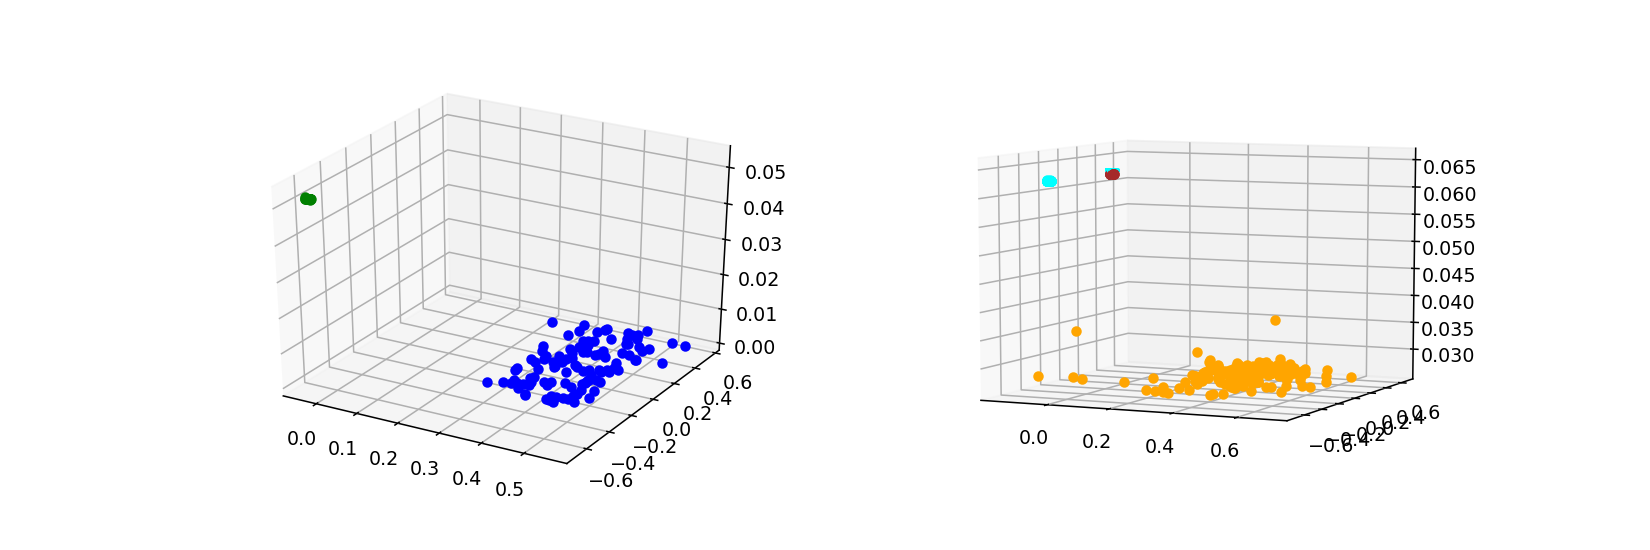

There are 602 data points in total and the success rate is :87.20930232558139%


In [125]:
fig = plt.figure(5, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
num_data = len(test_nut) + len(test_bolt)
num_mistakes = 0
for data in test_nut:
    sample = np.array(data[:3]).astype('float64')
    x = sample[0]
    y = sample[1]
    z = sample[2]
    i = pred_label(sample, models_nut)
    if label_nut[i] == data[3]:
        ax.scatter3D(x, z, y, c = colors[i],  marker = 'o')
    else:
        print(label_nut[i], data)
        num_mistakes += 1
        ax.scatter3D(x, z, y, c = colors[i],  marker = 'v')
        
ax = fig.add_subplot(1, 2, 2, projection='3d')        
for data in test_bolt:
    sample = np.array(data[:3]).astype('float64')
    x = sample[0]
    y = sample[1]
    z = sample[2]
    i = pred_label(sample, models_bolt)
    if label_bolt[i] == data[3]:
        ax.scatter3D(x, z, y, c = colors[i + 2],  marker = 'o')
    else:
        num_mistakes +=1
        ax.scatter3D(x, z, y, c = colors[i + 2],  marker = 'v')
print(f'There are {num_data} data points in total and the success rate is :{(num_data - num_mistakes)/num_data*100}%')
# plt.savefig('test.png')

## Success rate vs number of demonstrations 

In [230]:
def cal_success_rate(test_nut, test_bolt, models_nut, models_bolt):
    num_data = len(test_nut) + len(test_bolt)
    num_mistakes = 0
    for data in test_nut:
        sample = np.array(data[:3]).astype('float64')
        x = sample[0]
        y = sample[1]
        z = sample[2]
        i = pred_label(sample, models_nut)
        if not label_nut[i] == data[3]:
            num_mistakes += 1       
    for data in test_bolt:
        sample = np.array(data[:3]).astype('float64')
        x = sample[0]
        y = sample[1]
        z = sample[2]
        i = pred_label(sample, models_bolt)
        if not label_bolt[i] == data[3]:
            num_mistakes +=1
    return (num_data - num_mistakes)/num_data

seqs = []

logfile_path = '../sim_data/training/one_copy/1600455418/data.pickle'
with open(logfile_path, "rb") as logfile:
    while True:
        try:
            seqs.append(pickle.load(logfile))
        except EOFError:
            break  
            
seqs_success = []
for seq in seqs:
    if len(seq) == 4:
        seqs_success.append(seq)
    
label_nut = ['Nut in jig', 'Nut on table']        
label_bolt = ['Bolt on table', 'Bolt assembled', 'Bolt in jig']
colors = ['green','blue','orange','cyan','brown' ]

### One demonstration

In [195]:

success_rate_1 = 0
for k,seq in enumerate(seqs_success):
    data_nut = []
    data_bolt = []
    for step in seq:
        pos_nut = [obj['pos'] for obj in step['objs'] if obj['class'] == 'nut']
        pos_bolt = [obj['pos'] for obj in step['objs'] if obj['class'] == 'bolt']
        data_nut += pos_nut
        data_bolt += pos_bolt
    data_nut = np.asarray(data_nut).T
    data_bolt = np.asarray(data_bolt).T
    estimated_labels_nut = clustering(data_nut)
    estimated_labels_bolt = clustering(data_bolt)

    models_nut = build_model(estimated_labels_nut, data_nut)
    models_bolt = build_model(estimated_labels_bolt, data_bolt)
    success_rate_1  += cal_success_rate(test_nut, test_bolt, models_nut, models_bolt)
    if k == 4:
        break

success_rate_1 = success_rate_1 / (k + 1)
print(success_rate_1)

/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anacon

0.9990033222591361


/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


In [252]:
num_demonstrations = 1
success_rate_1 = 0
data_nut = []
data_bolt = []
for k,seq in enumerate(seqs_success):
    for step in seq:
        pos_nut = [obj['pos'] for obj in step['objs'] if obj['class'] == 'nut']
        pos_bolt = [obj['pos'] for obj in step['objs'] if obj['class'] == 'bolt']
        data_nut += pos_nut
        data_bolt += pos_bolt
data_nut = np.asarray(data_nut).T
data_bolt = np.asarray(data_bolt).T
for i in range(10):
    training_nut = data_nut[:,i * 4 * num_demonstrations: (i+1) * num_demonstrations * 4]
    training_bolt = data_bolt[:,i * 4 * num_demonstrations: (i+1) * num_demonstrations * 4]
    estimated_labels_nut = clustering(training_nut)
    estimated_labels_bolt = clustering(training_bolt)

    models_nut = build_model(estimated_labels_nut, training_nut)
    models_bolt = build_model(estimated_labels_bolt, training_bolt)
    success_rate_1  += cal_success_rate(test_nut, test_bolt, models_nut, models_bolt)
    print(cal_success_rate(test_nut, test_bolt, models_nut, models_bolt))
success_rate_1 = success_rate_1 / 5
print(success_rate_1)

/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anacon

0.9983388704318937
1.0
0.9983388704318937
0.9983388704318937


/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anacon

1.0
1.0
1.0
1.0
1.0
0.9983388704318937
1.998671096345515


/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


### Two demonstrations

In [255]:
num_demonstrations = 2
success_rate_2 = 0
data_nut = []
data_bolt = []
for k,seq in enumerate(seqs_success):
    for step in seq:
        pos_nut = [obj['pos'] for obj in step['objs'] if obj['class'] == 'nut']
        pos_bolt = [obj['pos'] for obj in step['objs'] if obj['class'] == 'bolt']
        data_nut += pos_nut
        data_bolt += pos_bolt
data_nut = np.asarray(data_nut).T
data_bolt = np.asarray(data_bolt).T
for i in range(5):
    training_nut = data_nut[:,i * 4 * num_demonstrations: (i+1) * num_demonstrations * 4]
    training_bolt = data_bolt[:,i * 4 * num_demonstrations: (i+1) * num_demonstrations * 4]
    estimated_labels_nut = clustering(training_nut)
    estimated_labels_bolt = clustering(training_bolt)
    print(estimated_labels_bolt)
    models_nut = build_model(estimated_labels_nut, training_nut)
    models_bolt = build_model(estimated_labels_bolt, training_bolt)
    success_rate_2  += cal_success_rate(test_nut, test_bolt, models_nut, models_bolt)
    print(cal_success_rate(test_nut, test_bolt, models_nut, models_bolt))
success_rate_2 = success_rate_2 / 5
# print(success_rate_2)

[0 0 2 1 0 0 2 1]
0.9983388704318937
[0 0 2 1 0 0 2 1]


/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anacon

0.9983388704318937
[0 0 2 1 0 0 2 1]
1.0
[0 0 2 1 0 0 2 1]
1.0
[1 1 2 0 1 1 2 0]

/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anacon


0.5913621262458472


/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/Xueyang/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


In [1]:
from utils.data import *

In [ ]:
fil